###### Imports

In [1]:
import requests
import urllib.request
from zipfile import ZipFile
import json
import io
import zipfile
import geopandas as gpd
from shapely.geometry import shape  
import osr
import pandas as pd
import pysal as ps
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Bring in the TIGER file that we want and examine and clean for use

Specify the zipped shapefile url and read it in with geopandas, then display the info about the geodataframe including the size and datatypes.

In [2]:
#extract GeoDataFrame from Tiger
url= 'https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip'
county = gpd.read_file(url)
county.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   3233 non-null   object  
 1   COUNTYFP  3233 non-null   object  
 2   COUNTYNS  3233 non-null   object  
 3   GEOID     3233 non-null   object  
 4   NAME      3233 non-null   object  
 5   NAMELSAD  3233 non-null   object  
 6   LSAD      3233 non-null   object  
 7   CLASSFP   3233 non-null   object  
 8   MTFCC     3233 non-null   object  
 9   CSAFP     1255 non-null   object  
 10  CBSAFP    1915 non-null   object  
 11  METDIVFP  110 non-null    object  
 12  FUNCSTAT  3233 non-null   object  
 13  ALAND     3233 non-null   int64   
 14  AWATER    3233 non-null   int64   
 15  INTPTLAT  3233 non-null   object  
 16  INTPTLON  3233 non-null   object  
 17  geometry  3233 non-null   geometry
dtypes: geometry(1), int64(2), object(15)
memory usage: 454.8+ KB


Look at the crs.

In [3]:
county.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Make sure the data looks correct by displaying the head.

In [4]:
county.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


## Bring in the population data using the Census API

###### The data we're curious about comes divided by sex or race - for now we're going to look at sex and then total them together because it's less data to deal with. You are only able to import 50 variables at once, so we're going to do total population and male population together, then female population. Eventually we will join them into one larger dataframe.

For duplication purposes, I'm going to create a list of variables and use string method .format() to iterate through the list to pull all of these variables, then I can copy paste that list into different notebooks where we're looking at different geographies. <-- come back to this... can't get the for loop right for now but ultimately will make it way better.

In [5]:
#male and total
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'
url_str= 'https://api.census.gov/data/2014/acs/acs5?get=NAME,GEO_ID,B01001_001E,B01001_002E,B01001_003E,B01001_004E,B01001_005E,B01001_006E,B01001_007E,B01001_008E,B01001_009E,B01001_010E,B01001_011E,B01001_012E,B01001_013E,B01001_014E,B01001_015E,B01001_016E,B01001_017E,B01001_018E,B01001_019E,B01001_020E,B01001_021E,B01001_022E,B01001_023E,B01001_024E,B01001_025E&for=county:*&in=state:*&key='+api_key

predicates= {}
get_vars= ["NAME", "GEO_ID",'B01001_001E','B01001_020E','B01001_003E','B01001_004E','B01001_005E','B01001_006E','B01001_007E','B01001_008E','B01001_009E','B01001_010E','B01001_011E','B01001_012E','B01001_013E','B01001_014E','B01001_015E','B01001_016E','B01001_017E','B01001_018E','B01001_019E','B01001_020E','B01001_021E','B01001_022E','B01001_023E','B01001_024E','B01001_025E', 'state']
predicates["get"]= ",". join(get_vars)
predicates["for"]= "state:*"
male= requests.get(url_str, params= predicates)

col_names = ['NAME', 'GEOID','total','mtotal','mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
            'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79','m80_84','m85+', 'StateFIPS', 'ind']
male=pd.DataFrame(columns=col_names, data=male.json()[1:])

In [6]:
male.head()

,NAME,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,m60_61,m62_64,m65_66,m67_69,m70_74,m75_79,m80_84,m85+,StateFIPS,ind
0,"McPherson County, Nebraska",0500000US31117,426,214,21,11,6,12,3,0,...,4,5,8,2,5,6,10,12,31,117
1,"Cheyenne County, Nebraska",0500000US31033,10044,5021,310,466,294,196,106,43,...,142,151,81,146,127,161,96,75,31,033
2,"Dawson County, Nebraska",0500000US31047,24205,12201,989,1069,820,574,318,172,...,297,295,151,286,360,287,181,198,31,047
3,"Garfield County, Nebraska",0500000US31071,1954,969,42,59,74,44,0,9,...,57,42,17,28,81,66,36,15,31,071
4,"Nance County, Nebraska",0500000US31125,3667,1840,115,118,138,77,17,21,...,53,108,45,24,79,64,50,40,31,125


In [7]:
#female
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'
url_str= 'https://api.census.gov/data/2014/acs/acs5?get=NAME,GEO_ID,B01001_026E,B01001_027E,B01001_028E,B01001_029E,B01001_030E,B01001_031E,B01001_032E,B01001_033E,B01001_034E,B01001_035E,B01001_036E,B01001_037E,B01001_038E,B01001_039E,B01001_040E,B01001_041E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E&for=county:*&in=state:*&key='+api_key

predicates= {}
get_vars= ["NAME","GEO_ID",'B01001_026E','B01001_027E','B01001_028E','B01001_029E','B01001_030E','B01001_031E','B01001_032E','B01001_033E','B01001_034E','B01001_035E','B01001_036E','B01001_037E','B01001_038E','B01001_039E','B01001_040E','B01001_041E','B01001_042E','B01001_043E','B01001_044E','B01001_045E','B01001_046E','B01001_047E','B01001_048E','B01001_049E', 'state']
predicates["get"]= ",". join(get_vars)
predicates["for"]= "state:*"
female= requests.get(url_str, params= predicates)

col_names = ['NAME','GEOID','ftotal', 'fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29','f30_34',
            'f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74','f75_79','f80_84','f85+','StateFIPS','ind']
female=pd.DataFrame(columns=col_names, data=female.json()[1:])

In [8]:
female.head()

,NAME,GEOID,ftotal,fu5,f5_9,f10_14,f15_17,f18_19,f20,f21,...,f60_61,f62_64,f65_66,f67_69,f70_74,f75_79,f80_84,f85+,StateFIPS,ind
0,"McPherson County, Nebraska",0500000US31117,212,13,11,12,4,3,0,0,...,7,3,10,2,2,14,6,12,31,117
1,"Cheyenne County, Nebraska",0500000US31033,5023,316,253,400,190,104,16,28,...,129,145,108,109,171,266,144,133,31,033
2,"Dawson County, Nebraska",0500000US31047,12004,861,1058,874,570,299,115,103,...,270,413,149,313,442,459,297,261,31,047
3,"Garfield County, Nebraska",0500000US31071,985,42,101,43,37,13,0,0,...,29,24,33,51,52,60,49,35,31,071
4,"Nance County, Nebraska",0500000US31125,1827,101,96,125,75,48,5,17,...,70,68,34,70,62,89,71,89,31,125


Join all of these back together into one bigger df

In [9]:
age_pop = pd.merge(male, female, how = 'inner', on = 'GEOID')

In [10]:
age_pop.head()

,NAME_x,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,f60_61,f62_64,f65_66,f67_69,f70_74,f75_79,f80_84,f85+,StateFIPS_y,ind_y
0,"McPherson County, Nebraska",0500000US31117,426,214,21,11,6,12,3,0,...,7,3,10,2,2,14,6,12,31,117
1,"Cheyenne County, Nebraska",0500000US31033,10044,5021,310,466,294,196,106,43,...,129,145,108,109,171,266,144,133,31,033
2,"Dawson County, Nebraska",0500000US31047,24205,12201,989,1069,820,574,318,172,...,270,413,149,313,442,459,297,261,31,047
3,"Garfield County, Nebraska",0500000US31071,1954,969,42,59,74,44,0,9,...,29,24,33,51,52,60,49,35,31,071
4,"Nance County, Nebraska",0500000US31125,3667,1840,115,118,138,77,17,21,...,70,68,34,70,62,89,71,89,31,125


Check out our datatypes and any extra columns from the join that are no longer necessary.

In [11]:
age_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220 entries, 0 to 3219
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   NAME_x       3220 non-null   object
 1   GEOID        3220 non-null   object
 2   total        3220 non-null   object
 3   mtotal       3220 non-null   object
 4   mu5          3220 non-null   object
 5   m5_9         3220 non-null   object
 6   m10_14       3220 non-null   object
 7   m15_17       3220 non-null   object
 8   m18_19       3220 non-null   object
 9   m20          3220 non-null   object
 10  m21          3220 non-null   object
 11  m22_24       3220 non-null   object
 12  m25_29       3220 non-null   object
 13  m30_34       3220 non-null   object
 14  m35_39       3220 non-null   object
 15  m40_44       3220 non-null   object
 16  m45_49       3220 non-null   object
 17  m50_54       3220 non-null   object
 18  m55_59       3220 non-null   object
 19  m60_61       3220 non-null 

Drop the indices and extra CBSA name column, rename the one you're going to keep, then convert all numeric columns to int64 as we're going to be performing mathematical operations on them.

In [12]:
#drop the indices and extra state name
age_pop = age_pop.drop(columns=['ind_x','NAME_y','StateFIPS_y','ind_y'])

In [13]:
#convert all numeric columns to integers
cols = ['total','mtotal','mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
        'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79',
        'm80_84','m85+','ftotal', 'fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29',
        'f30_34','f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74',
        'f75_79','f80_84','f85+']

age_pop[cols]=age_pop[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [14]:
age_pop = age_pop.rename(columns={'NAME_x':'NAME', 'StateFIPS_x':'StateFIPS'})

Check that the last few steps were effective.

In [15]:
age_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220 entries, 0 to 3219
Data columns (total 52 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   NAME       3220 non-null   object
 1   GEOID      3220 non-null   object
 2   total      3220 non-null   int64 
 3   mtotal     3220 non-null   int64 
 4   mu5        3220 non-null   int64 
 5   m5_9       3220 non-null   int64 
 6   m10_14     3220 non-null   int64 
 7   m15_17     3220 non-null   int64 
 8   m18_19     3220 non-null   int64 
 9   m20        3220 non-null   int64 
 10  m21        3220 non-null   int64 
 11  m22_24     3220 non-null   int64 
 12  m25_29     3220 non-null   int64 
 13  m30_34     3220 non-null   int64 
 14  m35_39     3220 non-null   int64 
 15  m40_44     3220 non-null   int64 
 16  m45_49     3220 non-null   int64 
 17  m50_54     3220 non-null   int64 
 18  m55_59     3220 non-null   int64 
 19  m60_61     3220 non-null   int64 
 20  m62_64     3220 non-null   int

Create columns of totals for each one of these age groups.

In [16]:
#create totals columns
age_pop['tu5'] = age_pop['mu5']+age_pop['fu5']
age_pop['t5_9'] = age_pop['m5_9']+age_pop['f5_9']
age_pop['t10_14'] = age_pop['m10_14']+age_pop['f10_14']
age_pop['t15_17'] = age_pop['m15_17']+age_pop['f15_17']
age_pop['t18_19'] = age_pop['m18_19']+age_pop['f18_19']
age_pop['t20'] = age_pop['m20']+age_pop['f20']
age_pop['t21'] = age_pop['m21']+age_pop['f21']
age_pop['t22_24'] = age_pop['m22_24']+age_pop['f22_24']
age_pop['t25_29'] = age_pop['m25_29']+age_pop['f25_29']
age_pop['t30_34'] = age_pop['m30_34']+age_pop['f30_34']
age_pop['t35_39'] = age_pop['m35_39']+age_pop['f35_39']
age_pop['t40_44'] = age_pop['m40_44']+age_pop['f40_44']
age_pop['t45_49'] = age_pop['m45_49']+age_pop['f45_49']
age_pop['t50_54'] = age_pop['m50_54']+age_pop['f50_54']
age_pop['t55_59'] = age_pop['m55_59']+age_pop['f55_59']
age_pop['t60_61'] = age_pop['m60_61']+age_pop['f60_61']
age_pop['t62_64'] = age_pop['m62_64']+age_pop['f62_64']
age_pop['t65_66'] = age_pop['m65_66']+age_pop['f65_66']
age_pop['t67_69'] = age_pop['m67_69']+age_pop['f67_69']
age_pop['t70_74'] = age_pop['m70_74']+age_pop['f70_74']
age_pop['t75_79'] = age_pop['m75_79']+age_pop['f75_79']
age_pop['t80_84'] = age_pop['m80_84']+age_pop['f80_84']
age_pop['t85+'] = age_pop['m85+']+age_pop['f85+']

In [17]:
age_pop.head(3)

,NAME,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,t50_54,t55_59,t60_61,t62_64,t65_66,t67_69,t70_74,t75_79,t80_84,t85+
0,"McPherson County, Nebraska",0500000US31117,426,214,21,11,6,12,3,0,...,35,40,11,8,18,4,7,20,16,24
1,"Cheyenne County, Nebraska",0500000US31033,10044,5021,310,466,294,196,106,43,...,801,761,271,296,189,255,298,427,240,208
2,"Dawson County, Nebraska",0500000US31047,24205,12201,989,1069,820,574,318,172,...,1613,1724,567,708,300,599,802,746,478,459


## Create groups for analysis. Since we're looking at ageing services, it makes sense to group people into some rough "stage of life" that is predicated on services provided to them or their position in the workforce.

###### So we're going to do:  
- Under 5: this group needs childcare outside of the public school system  
- Over 5 but under 18: presumably in the school system  
- 18, 19, 20s: out of the school system, likely in college or in the workforce  
- 30s: beginning-mid career  
- 40s: established career  
- 50-64: height of career, then considering retirement  
- 65+: supposedly retiring, officially an older person? what's the term? eligible for medicaid. anyway.

In [18]:
#school is under 18, again for males, females, and total
age_pop['mschool']=age_pop['m5_9']+age_pop['m10_14']+age_pop['m15_17']
age_pop['fschool']=age_pop['f5_9']+age_pop['f10_14']+age_pop['f15_17']
age_pop['tschool']=age_pop['t5_9']+age_pop['t10_14']+age_pop['t15_17']

In [19]:
#18/19/20s
age_pop['m18_20s']=age_pop['m18_19']+age_pop['m20']+age_pop['m21']+age_pop['m22_24']+age_pop['m25_29']
age_pop['f18_20s']=age_pop['f18_19']+age_pop['f20']+age_pop['f21']+age_pop['f22_24']+age_pop['f25_29']
age_pop['t18_20s']=age_pop['t18_19']+age_pop['t20']+age_pop['t21']+age_pop['t22_24']+age_pop['t25_29']

In [20]:
#30s
age_pop['m30s']=age_pop['m30_34']+age_pop['m35_39']
age_pop['f30s']=age_pop['f30_34']+age_pop['f35_39']
age_pop['t30s']=age_pop['t30_34']+age_pop['t35_39']

In [21]:
#40s
age_pop['m40s']=age_pop['m40_44']+age_pop['m45_49']
age_pop['f40s']=age_pop['f40_44']+age_pop['f45_49']
age_pop['t40s']=age_pop['t40_44']+age_pop['t45_49']

In [22]:
#50 - 64
age_pop['m50_65']=age_pop['m50_54']+age_pop['m55_59']+age_pop['m60_61']+age_pop['m62_64']
age_pop['f50_65']=age_pop['f50_54']+age_pop['f55_59']+age_pop['f60_61']+age_pop['f62_64']
age_pop['t50_65']=age_pop['t50_54']+age_pop['t55_59']+age_pop['t60_61']+age_pop['t62_64']

In [23]:
#over 65
age_pop['mo65']=age_pop['m65_66']+age_pop['m67_69']+age_pop['m70_74']+age_pop['m75_79']+age_pop['m80_84']+age_pop['m85+']
age_pop['fo65']=age_pop['f65_66']+age_pop['f67_69']+age_pop['f70_74']+age_pop['f75_79']+age_pop['f80_84']+age_pop['f85+']
age_pop['to65']=age_pop['t65_66']+age_pop['t67_69']+age_pop['t70_74']+age_pop['t75_79']+age_pop['t80_84']+age_pop['t85+']

Make these groups into shares of the total - at this point the data is "highly fragmented" so create a copy of the same name before moving on.

In [25]:
age_pop['Pmschool']=round(age_pop['mschool']*100/age_pop['total'],1)
age_pop['Pfschool']=round(age_pop['fschool']*100/age_pop['total'],1)
age_pop['Ptschool']=round(age_pop['tschool']*100/age_pop['total'],1)
age_pop['Pm18_20s']=round(age_pop['m18_20s']*100/age_pop['total'],1)
age_pop['Pf18_20s']=round(age_pop['f18_20s']*100/age_pop['total'],1)
age_pop['Pt18_20s']=round(age_pop['t18_20s']*100/age_pop['total'],1)
age_pop['Pm30s']=round(age_pop['m30s']*100/age_pop['total'],1)
age_pop['Pf30s']=round(age_pop['f30s']*100/age_pop['total'],1)
age_pop['Pt30s']=round(age_pop['t30s']*100/age_pop['total'],1)
age_pop['Pm40s']=round(age_pop['m40s']*100/age_pop['total'],1)
age_pop['Pf40s']=round(age_pop['f40s']*100/age_pop['total'],1)
age_pop['Pt40s']=round(age_pop['t40s']*100/age_pop['total'],1)
age_pop['Pm50_65']=round(age_pop['m50_65']*100/age_pop['total'],1)
age_pop['Pf50_65']=round(age_pop['f50_65']*100/age_pop['total'],1)
age_pop['Pt50_65']=round(age_pop['t50_65']*100/age_pop['total'],1)
age_pop['Pmo65']=round(age_pop['mo65']*100/age_pop['total'],1)
age_pop['Pfo65']=round(age_pop['fo65']*100/age_pop['total'],1)
age_pop['Pto65']=round(age_pop['to65']*100/age_pop['total'],1)
age_pop = age_pop.copy()

In [26]:
age_pop.head(2)

,NAME,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,"McPherson County, Nebraska",0500000US31117,426,214,21,11,6,12,3,0,...,8.5,9.2,8.0,17.1,10.8,11.3,22.1,10.1,10.8,20.9
1,"Cheyenne County, Nebraska",0500000US31033,10044,5021,310,466,294,196,106,43,...,12.7,5.7,6.6,12.4,10.7,10.5,21.2,6.8,9.3,16.1


Make a separate dataframe of only these created groups and their shares

In [27]:
agegroups = age_pop.drop(columns = ['mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
        'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79',
        'm80_84','m85+','fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29',
        'f30_34','f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74',
        'f75_79','f80_84','f85+','tu5','t5_9','t10_14','t15_17','t18_19','t20','t21','t22_24','t25_29',
        't30_34','t35_39','t40_44','t45_49','t50_54','t55_59','t60_61','t62_64','t65_66','t67_69','t70_74',
        't75_79','t80_84','t85+'])

In [28]:
agegroups.head()

,NAME,GEOID,total,mtotal,StateFIPS,ftotal,mschool,fschool,tschool,m18_20s,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,"McPherson County, Nebraska",0500000US31117,426,214,31,212,29,27,56,21,...,8.5,9.2,8.0,17.1,10.8,11.3,22.1,10.1,10.8,20.9
1,"Cheyenne County, Nebraska",0500000US31033,10044,5021,31,5023,956,843,1799,730,...,12.7,5.7,6.6,12.4,10.7,10.5,21.2,6.8,9.3,16.1
2,"Dawson County, Nebraska",0500000US31047,24205,12201,31,12004,2463,2502,4965,1840,...,11.3,6.7,6.2,12.9,10.0,9.0,19.1,6.0,7.9,14.0
3,"Garfield County, Nebraska",0500000US31071,1954,969,31,985,177,181,358,89,...,9.5,3.6,4.7,8.2,12.6,11.4,24.0,12.4,14.3,26.8
4,"Nance County, Nebraska",0500000US31125,3667,1840,31,1827,333,296,629,216,...,8.2,6.8,6.6,13.4,13.0,11.5,24.5,8.2,11.3,19.6


Before the export and the joining, we need to split the full GEOID so that we have the county FIPS, let's also split up the full NAME so that we have the county and state. Start with the geography name.

In [29]:
# Split the Name column at the comma then name the new column as the first column you index into
name = agegroups['NAME'].str.split(pat = ',', expand = True)
name

,0,1
0,McPherson County,Nebraska
1,Cheyenne County,Nebraska
2,Dawson County,Nebraska
3,Garfield County,Nebraska
4,Nance County,Nebraska
...,...,...
3215,Copiah County,Mississippi
3216,Hinds County,Mississippi
3217,Union County,Mississippi
3218,Tippah County,Mississippi


In [30]:
agegroups['County'] = name[0]
agegroups['State'] = name[1]

Now we're going to split the GEOIDs.

In [31]:
agegroups['CountyFIPS'] = agegroups['GEOID'].str.slice(start = 9)

In [32]:
agegroups.head()

,NAME,GEOID,total,mtotal,StateFIPS,ftotal,mschool,fschool,tschool,m18_20s,...,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,County,State,CountyFIPS
0,"McPherson County, Nebraska",0500000US31117,426,214,31,212,29,27,56,21,...,17.1,10.8,11.3,22.1,10.1,10.8,20.9,McPherson County,Nebraska,31117
1,"Cheyenne County, Nebraska",0500000US31033,10044,5021,31,5023,956,843,1799,730,...,12.4,10.7,10.5,21.2,6.8,9.3,16.1,Cheyenne County,Nebraska,31033
2,"Dawson County, Nebraska",0500000US31047,24205,12201,31,12004,2463,2502,4965,1840,...,12.9,10.0,9.0,19.1,6.0,7.9,14.0,Dawson County,Nebraska,31047
3,"Garfield County, Nebraska",0500000US31071,1954,969,31,985,177,181,358,89,...,8.2,12.6,11.4,24.0,12.4,14.3,26.8,Garfield County,Nebraska,31071
4,"Nance County, Nebraska",0500000US31125,3667,1840,31,1827,333,296,629,216,...,13.4,13.0,11.5,24.5,8.2,11.3,19.6,Nance County,Nebraska,31125


## Export this file before joining for statistical analysis or to join to another geodataframe from a current year.

In [33]:
agegroups.to_csv('../output/csv/agegroups_2014_county.csv')

## Join the geodataframe so that we can perform spatial analysis.

In [34]:
agegroups_geo = county.merge(agegroups, left_on='GEOID', right_on='CountyFIPS')

In [35]:
agegroups_geo.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID_x,NAME_x,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,County,State,CountyFIPS
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,13.8,10.9,9.7,20.6,9.2,11.7,20.9,Cuming County,Nebraska,31039
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,11.2,11.3,12.7,24.0,13.9,14.4,28.3,Wahkiakum County,Washington,53069
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,11.1,14.3,12.4,26.7,8.1,10.9,19.0,De Baca County,New Mexico,35011


In [36]:
agegroups_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3218 entries, 0 to 3217
Data columns (total 63 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP     3218 non-null   object  
 1   COUNTYFP    3218 non-null   object  
 2   COUNTYNS    3218 non-null   object  
 3   GEOID_x     3218 non-null   object  
 4   NAME_x      3218 non-null   object  
 5   NAMELSAD    3218 non-null   object  
 6   LSAD        3218 non-null   object  
 7   CLASSFP     3218 non-null   object  
 8   MTFCC       3218 non-null   object  
 9   CSAFP       1255 non-null   object  
 10  CBSAFP      1915 non-null   object  
 11  METDIVFP    110 non-null    object  
 12  FUNCSTAT    3218 non-null   object  
 13  ALAND       3218 non-null   int64   
 14  AWATER      3218 non-null   int64   
 15  INTPTLAT    3218 non-null   object  
 16  INTPTLON    3218 non-null   object  
 17  geometry    3218 non-null   geometry
 18  NAME_y      3218 non-null   object  
 19

We already know that not every county is in a combined or statistical area, but I'm not sure what METDIVFP is so we're going to look at those null values.

In [37]:
nullMETDIVFP = agegroups_geo[agegroups_geo['METDIVFP'].isnull()]

In [38]:
nullMETDIVFP.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID_x,NAME_x,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,County,State,CountyFIPS
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,13.8,10.9,9.7,20.6,9.2,11.7,20.9,Cuming County,Nebraska,31039
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,11.2,11.3,12.7,24.0,13.9,14.4,28.3,Wahkiakum County,Washington,53069
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,11.1,14.3,12.4,26.7,8.1,10.9,19.0,De Baca County,New Mexico,35011


In [39]:
agegroups_geo.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID_x', 'NAME_x', 'NAMELSAD',
       'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT',
       'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'NAME_y',
       'GEOID_y', 'total', 'mtotal', 'StateFIPS', 'ftotal', 'mschool',
       'fschool', 'tschool', 'm18_20s', 'f18_20s', 't18_20s', 'm30s', 'f30s',
       't30s', 'm40s', 'f40s', 't40s', 'm50_65', 'f50_65', 't50_65', 'mo65',
       'fo65', 'to65', 'Pmschool', 'Pfschool', 'Ptschool', 'Pm18_20s',
       'Pf18_20s', 'Pt18_20s', 'Pm30s', 'Pf30s', 'Pt30s', 'Pm40s', 'Pf40s',
       'Pt40s', 'Pm50_65', 'Pf50_65', 'Pt50_65', 'Pmo65', 'Pfo65', 'Pto65',
       'County', 'State', 'CountyFIPS'],
      dtype='object')

This just means that those geographies are <i>not</i> in a metropolitan division. Moving on.

In [40]:
agegroups_geo = agegroups_geo.drop(columns=['COUNTYNS', 'GEOID_y', 'NAME_x', 'LSAD', 'CLASSFP',
                                            'MTFCC', 'FUNCSTAT', 'County', 'CountyFIPS'])
agegroups_geo = agegroups_geo.rename(columns={'STATEFP':'StateFIPS', 'COUNTYFP':'CountyFIPS', 
                                              'GEOID_x':'StateCountyFIPS', 'NAMELSAD':'County'})

In [41]:
agegroups_geo.head()

,StateFIPS,CountyFIPS,StateCountyFIPS,County,CSAFP,CBSAFP,METDIVFP,ALAND,AWATER,INTPTLAT,...,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,State
0,31,039,31039,Cuming County,None,None,None,1477652222,10690952,+41.9158651,...,7.2,6.6,13.8,10.9,9.7,20.6,9.2,11.7,20.9,Nebraska
1,53,069,53069,Wahkiakum County,None,None,None,680962890,61582307,+46.2946377,...,5.7,5.6,11.2,11.3,12.7,24.0,13.9,14.4,28.3,Washington
2,35,011,35011,De Baca County,None,None,None,6016819475,29089486,+34.3592729,...,3.7,7.5,11.1,14.3,12.4,26.7,8.1,10.9,19.0,New Mexico
3,31,109,31109,Lancaster County,339,30700,None,2169270569,22849484,+40.7835474,...,6.1,5.5,11.6,8.7,9.1,17.7,5.0,6.5,11.5,Nebraska
4,31,129,31129,Nuckolls County,None,None,None,1489645188,1718484,+40.1764918,...,5.4,5.6,10.9,11.4,11.7,23.2,11.8,14.4,26.2,Nebraska


## Export this file if you want so that we can create maps in another notebook.

In [42]:
#agegroups_geo.to_file('../output/shapefiles/2019_County/2019County.shp')

### Make some quick maps:

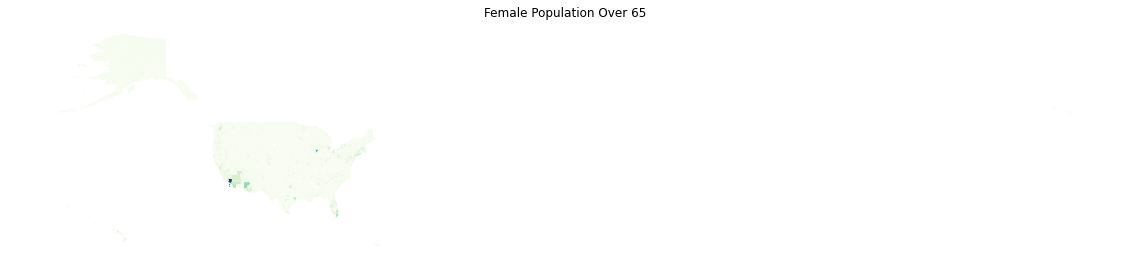

In [43]:
fig, ax = plt.subplots(figsize=(20, 20))
agegroups_geo.plot(column = 'fo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'none',
                  ax = ax)
plt.title('Female Population Over 65', fontsize=12)
ax.axis('off');

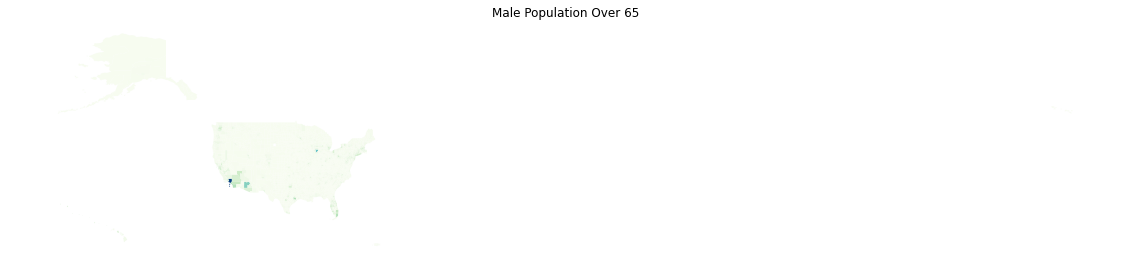

In [44]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'mo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'none',
                  ax = ax)
plt.title('Male Population Over 65', fontsize=12)
ax.axis('off');

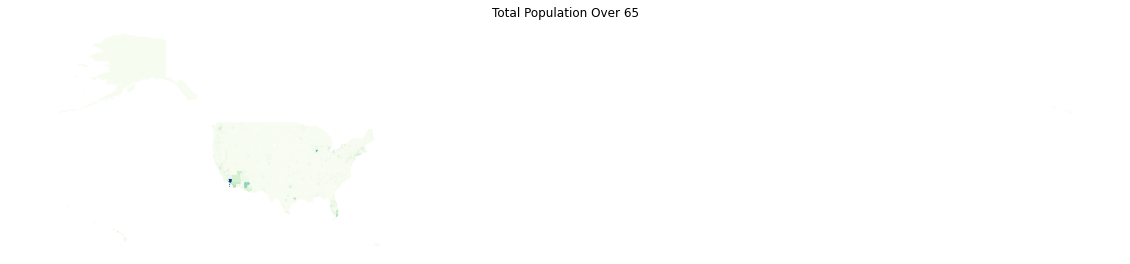

In [45]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'to65', 
                  cmap = 'GnBu', 
                  edgecolor = 'none',
                  ax = ax)
plt.title('Total Population Over 65', fontsize=12)
ax.axis('off');

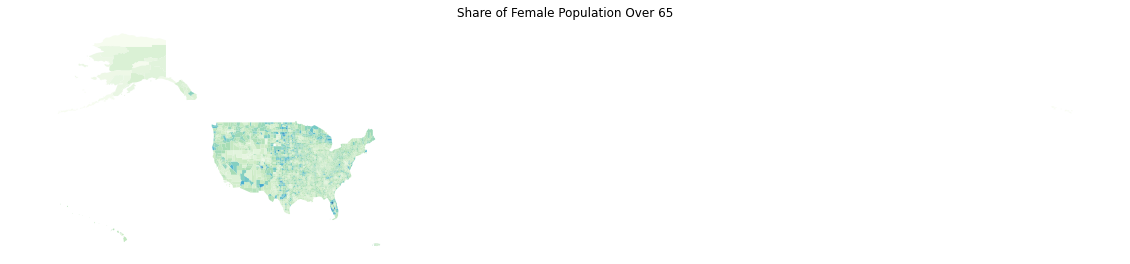

In [46]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pfo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'none',
                  ax = ax)
plt.title('Share of Female Population Over 65', fontsize=12)
ax.axis('off');

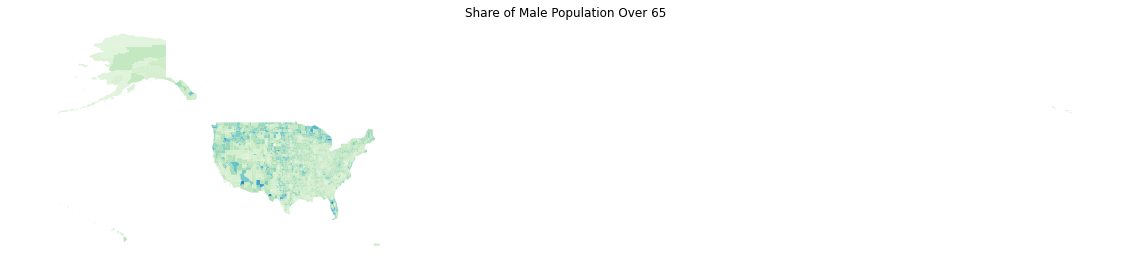

In [47]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pmo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'none',
                  ax = ax)
plt.title('Share of Male Population Over 65', fontsize=12)
ax.axis('off');

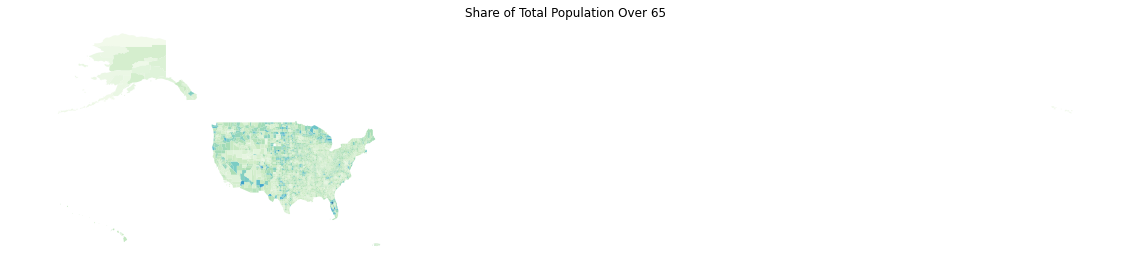

In [49]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pto65', 
                  cmap = 'GnBu', 
                  edgecolor = 'none',
                  ax = ax)
plt.title('Share of Total Population Over 65', fontsize=12)
ax.axis('off');